In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from google.colab import drive
from wordcloud import WordCloud
from collections import Counter

from sklearn.manifold import TSNE
from gensim.models import word2vec

import nltk 
import re
nltk.download('stopwords')
STOP_WORDS = nltk.corpus.stopwords.words()

# Mount drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Reading the training data
data_train = pd.read_csv('/content/drive/MyDrive/NLP/train.csv').sample(50000, random_state=23)
data_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
237921,237921,9732,79801,Is sex necessary in a relationship?,Why is sex important in a good relationship?,1
181001,181001,277377,277378,What are the most inspiring start up stories?,What are the most inspirational stories ever?,0
294691,294691,150129,93109,What is your best way to do digital marketing?,What are the best unique ways to do Digital Ma...,1
104145,104145,171986,171987,What is the best way to grow a Facebook fan page?,How do I get more followers on my Facebook page?,1
357893,357893,487310,487311,Suppose Host A sends two TCP segments back to ...,Suppose Host A sends two TCP segments back to ...,1


In [3]:
#Reading the test data 
data_test = pd.read_csv('/content/drive/MyDrive/NLP/test.csv')
data_test.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [4]:
q_ids = pd.Series(data_train['qid1'].tolist() + data_train['qid2'].tolist())
unique_questions = len(np.unique(q_ids))
duplicate_questions = np.sum(q_ids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_questions))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(duplicate_questions,duplicate_questions/unique_questions*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(q_ids.value_counts()))) 

q_vals = q_ids.value_counts()
q_vals = q_vals.values

Total number of  Unique Questions are: 88754

Number of unique questions that appear more than one time: 7397 (8.334272258151746%)

Max number of times a single question is repeated: 20



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


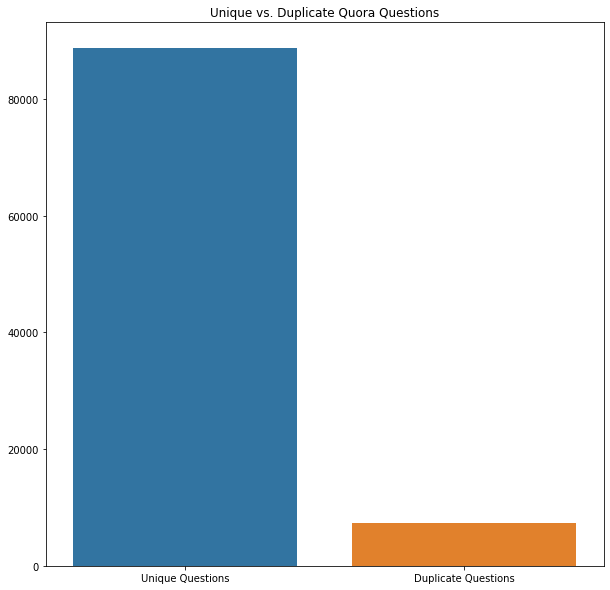

In [5]:
x = ["Unique Questions" , "Duplicate Questions"]
y =  [unique_questions , duplicate_questions]

plt.figure(figsize=(10, 10))
plt.title ("Unique vs. Duplicate Quora Questions")
sns.barplot(x,y)
plt.show()

Text(0, 0.5, 'Probability')

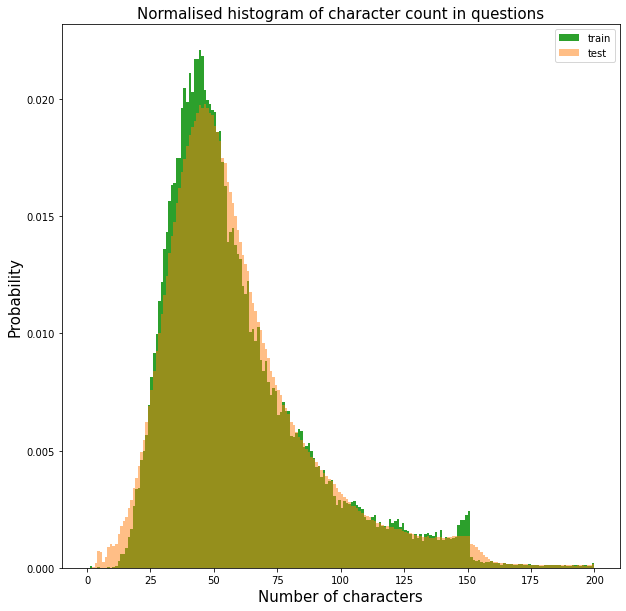

In [6]:
train_questions = pd.Series(data_train['question1'].tolist() + data_train['question2'].tolist()).astype(str)
test_questions = pd.Series(data_test['question1'].tolist() + data_test['question2'].tolist()).astype(str)

dist_train = train_questions.apply(len)
dist_test = test_questions.apply(len)

plt.figure(figsize=(10, 10))
pal = sns.color_palette()

plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2], density=True, label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1], density=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

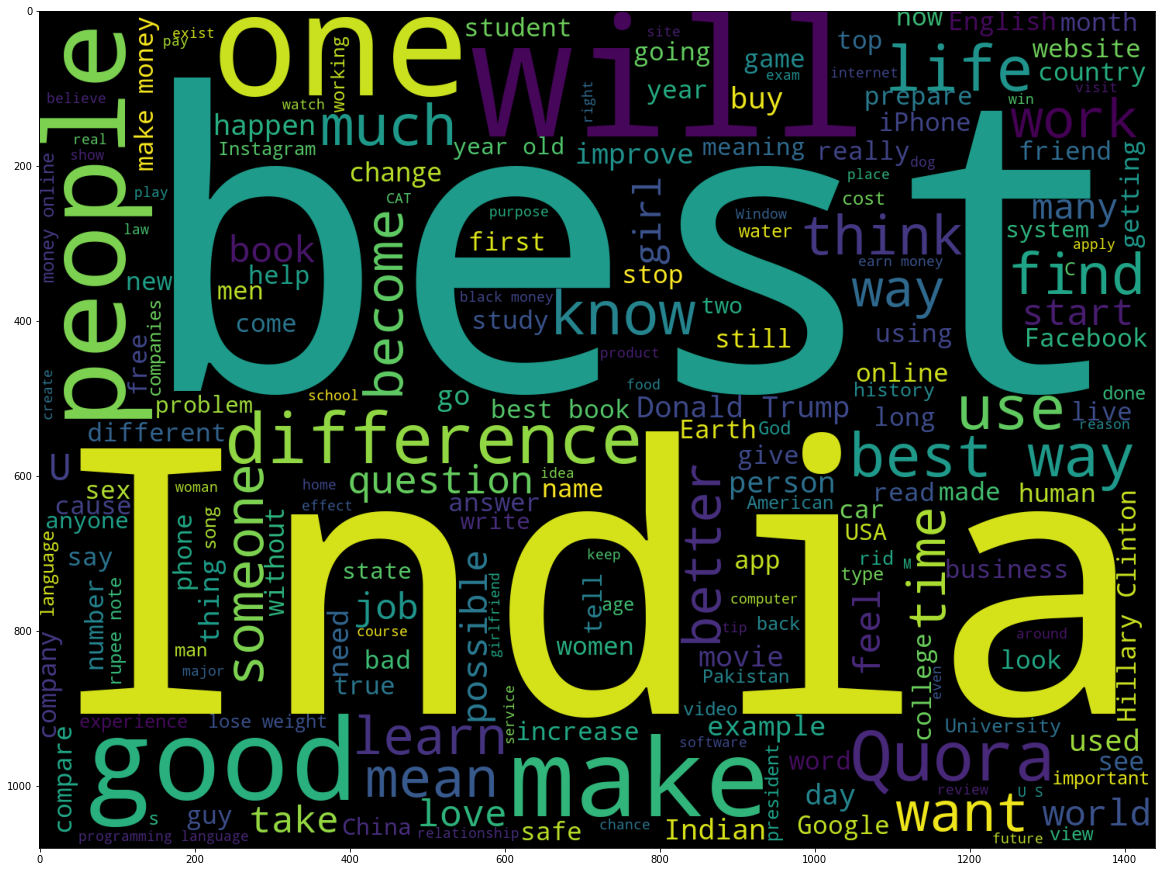

In [7]:
word_cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_questions.astype(str)))
plt.figure(figsize=(20, 20))
plt.imshow(word_cloud)

In [8]:
qmarks = np.mean(train_questions.apply(lambda x: '?' in x))
math = np.mean(train_questions.apply(lambda x: '[math]' in x))
capitals = np.mean(train_questions.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_questions.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

Questions with question marks: 99.87%
Questions with [math] tags: 0.11%
Questions with capital letters: 99.96%
Questions with numbers: 11.96%


In [9]:
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_questions)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [10]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('the', 1.760532384993222e-05), ('what', 2.064963759886014e-05), ('is', 2.3056881326231813e-05), ('how', 2.6973808432012517e-05), ('i', 2.7522430781086585e-05), ('a', 2.7757730527952033e-05), ('to', 2.858694719990852e-05), ('in', 2.9417821316153325e-05), ('of', 3.355479498020267e-05), ('do', 3.451489317640562e-05)]

Least common words and weights: 


[('170.', 9.998000399920016e-05),
 ('"end', 9.998000399920016e-05),
 ('fantasies', 9.998000399920016e-05),
 ('antonio', 9.998000399920016e-05),
 ('coweta', 9.998000399920016e-05),
 ('saber', 9.998000399920016e-05),
 ('lions?', 9.998000399920016e-05),
 ('jellyfishes', 9.998000399920016e-05),
 ('stung', 9.998000399920016e-05),
 ('flashback?', 9.998000399920016e-05)]

In [11]:
def clean_text(message):
    regex = re.compile('([^\s\w]|_)+')
    text = regex.sub('', message).lower()
    text = text.split(" ")
    
    for word in list(text):
        if word in STOP_WORDS:
            text.remove(word)  
            
    text = " ".join(text)
    return text

def clean_dataframe(data):
    data = data.dropna(how="any")
    
    for col in ['question1', 'question2']:
        data[col] = data[col].apply(clean_text)
    
    return data

In [12]:
data = clean_dataframe(data_train)
data.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id,qid1,qid2,question1,question2,is_duplicate
237921,237921,9732,79801,sex relationship,sex important relationship,1
181001,181001,277377,277378,inspiring start stories,inspirational stories,0
294691,294691,150129,93109,digital marketing,unique ways digital marketing,1
104145,104145,171986,171987,grow facebook page,followers facebook page,1
357893,357893,487310,487311,suppose host sends tcp segments back back host...,suppose host sends tcp segments back back host...,1


In [13]:
def build_corpus(data):
    corpus = []
    for col in ['question1', 'question2']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

corpus = build_corpus(data)        
corpus[0:2]

[['sex', 'relationship'], ['inspiring', 'start', 'stories']]

In [14]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=500, workers=4)

In [15]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


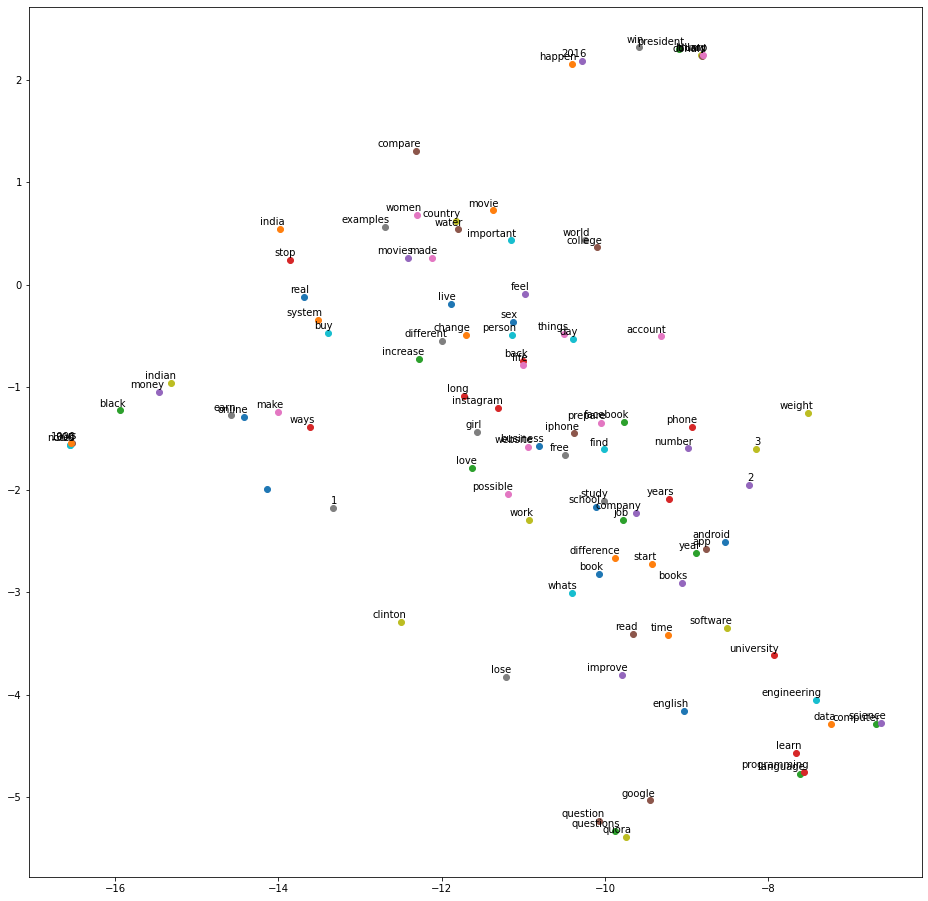

In [16]:
tsne_plot(model)